# SC4001: Neural Networks and Deep Learning Group Project 

Project Idea B: Creating models that focus on improving Q3 and Q8 prediction by exploring novel architectures 
or feature representations.

## Configuration & Imports, Dataset loading & preprocessing

In [ ]:


CULLED_CSV = r".\culled dataset\2018-06-06-pdb-intersect-pisces.csv" # dataset path
MAX_LEN    = 256          # Fixed Sequence Length — sequences longer than this get truncated; shorter ones are padded. 128/256 typical.
EMB_DIM    = 64           # embedding dimension for amino acid tokens.
LSTM_UNITS = 128          # keep small for speed; bump to 192/256 if needed
DROPOUT    = 0.20         # dropout rate between LSTM layers
BATCH_SIZE = 128          # 128–256 on a single GPU
EPOCHS     = 30
SEED       = 42
USE_LEN_STRATIFY = True   # keep length distributions similar across train/val/test splits

import os, numpy as np, pandas as pd, tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
np.random.seed(SEED); tf.random.set_seed(SEED)


In [ ]:
train_csv = r".\data\processed\train.csv"
validation_csv  = r".\data\processed\val.csv"
test_csv  = r".\data\processed\test.csv"

def load_and_clean(path):
    df = pd.read_csv(path)
    # Ensure required columns exist and are consistent
    df = df.dropna(subset=["seq", "sst8", "sst3", "len"]).copy()
    df = df[
        (df["seq"].str.len() > 0) &
        (df["seq"].str.len() == df["sst8"].str.len()) &
        (df["seq"].str.len() == df["sst3"].str.len())
    ].reset_index(drop=True)
    return df

df_train = load_and_clean(train_csv)
df_val   = load_and_clean(validation_csv)
df_test  = load_and_clean(test_csv)

print("Train df:", df_train.shape)
print("Val df:  ", df_val.shape)
print("Test df: ", df_test.shape)

Train df: (7196, 7)
Val df:   (899, 7)
Test df:  (899, 7)


Defines vocabulary (token IDs) for amino acids and maps structure labels (Q8, Q3) to integer class IDs.
Reserves 0 for <PAD> to leverage mask_zero=True in the embedding.
Maps Q8 and Q3 letters to class IDs (int).

PAD=0 → makes Keras masking automatic at the embedding layer.

In [ ]:
#Vocab / label maps
AA = list("ACDEFGHIKLMNPQRSTVWY")  # Standard 20 Amino Acids
SPECIALS = ["X","*"]               # unknown/nonstd masked in dataset
PAD = "<PAD>"                       # Padding token (idx=0)
VOCAB = [PAD] + AA + SPECIALS
aa2idx = {a:i for i,a in enumerate(VOCAB)}  # PAD=0

# Ordered List of Structure Classes
Q8 = ["C","E","H","B","G","I","T","S"]
Q3 = ["C","E","H"]

# Map class labels to indices
q8_to_idx = {c:i for i,c in enumerate(Q8)}
q3_to_idx = {c:i for i,c in enumerate(Q3)}

In [7]:
# Converts each amino acid sequence string to a fixed length of token IDs 
# Does padding with 0 if shorter than max_len.
# Truncates if longer than max_len.
def encode_seq(s, max_len=MAX_LEN):
    s = s.strip().upper() 
    out = np.full((max_len,), aa2idx[PAD], dtype=np.int32)
    L = min(len(s), max_len)                                # number of characters to actually encode
    for i in range(L):
        out[i] = aa2idx.get(s[i], aa2idx["X"])
    return out

#Converts Q8/Q3 labels to class IDs. Pads with -1 for masking.
def encode_labels(lbl, mapping, max_len=MAX_LEN):
    out = np.full((max_len,), -1, dtype=np.int32)  # -1 marks padding for our mask
    L = min(len(lbl), max_len)
    for i in range(L):
        out[i] = mapping[lbl[i]]
    return out

In [8]:
def build_arrays(rows):
    X  = np.stack([encode_seq(s) for s in rows['seq']], axis=0)
    y8 = np.stack([encode_labels(s, q8_to_idx) for s in rows['sst8']], axis=0)
    y3 = np.stack([encode_labels(s, q3_to_idx) for s in rows['sst3']], axis=0)
    m  = (y8 != -1).astype("float32")  # mask—same for both heads
    return X, y8, y3, m

Xtr, y8tr, y3tr, mtr = build_arrays(df_train)
Xva, y8va, y3va, mva = build_arrays(df_val)
Xte, y8te, y3te, mte = build_arrays(df_test)

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (7196, 256) Val: (899, 256) Test: (899, 256)


In [9]:
# pass sample weights via dataset
def ds_with_weights(X, y8, y3, mask, batch_size=32, shuffle=False, seed=42):
    sample_weights = mask.astype("float32")

    ds = tf.data.Dataset.from_tensor_slices((
        {"tokens": X},                                 # input key matches model input name ("tokens")
        {"q8": y8, "q3": y3},                          # targets dict keys match model outputs ("q8", "q3")
        {"q8": sample_weights, "q3": sample_weights},  # sample weights per head, per position
    ))
    # shuffle training data 
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=seed)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# build datasets with sample weights
# Batch Size 128, len Xtr = 7262 --> 7262/128 ≈ 57 batches per epoch
train_ds = ds_with_weights(Xtr, y8tr, y3tr, mtr, batch_size=BATCH_SIZE, shuffle=True,  seed=SEED)
val_ds   = ds_with_weights(Xva, y8va, y3va, mva, batch_size=BATCH_SIZE, shuffle=False, seed=SEED)
test_inp = tf.data.Dataset.from_tensor_slices({"tokens": Xte}).batch(BATCH_SIZE)


## CNN-BiLSTM Model Buidling & Configuration

In [ ]:
# Model
import tensorflow as tf
from tensorflow.keras import layers

def build_model(vocab_size=len(VOCAB), emb=EMB_DIM, lstm=LSTM_UNITS, p=DROPOUT):
    tokens = layers.Input(shape=(MAX_LEN,), dtype="int32", name="tokens")

    # Embedding
    embd = layers.Embedding(
        input_dim=vocab_size,
        output_dim=emb,
        mask_zero=True,
        name="aa_emb"
    )(tokens)

    # CNN 
    c3  = layers.Conv1D(128, 3, padding="same", activation="relu")(embd)
    c7  = layers.Conv1D(128, 7, padding="same", activation="relu")(embd)
    c11 = layers.Conv1D(128, 11, padding="same", activation="relu")(embd)

    x = layers.Concatenate()([c3, c7, c11])
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(p)(x)

    # BiLSTM
    x = layers.Bidirectional(
        layers.LSTM(lstm, return_sequences=True)
    )(x)
    x = layers.Dropout(p)(x)

    # Self-Attention 
    attn_out = layers.Attention()([x, x])
    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization()(x)

    # FFN
    ff = layers.Dense(4 * (2 * lstm), activation="relu")(x)
    ff = layers.Dropout(p)(ff)
    x = layers.Dense(2 * lstm)(ff)
    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization()(x)

    #  Softmax Output
    q8 = layers.Dense(len(Q8), activation="softmax", name="q8")(x)
    q3 = layers.Dense(len(Q3), activation="softmax", name="q3")(x)

    return tf.keras.Model(inputs={"tokens": tokens}, outputs={"q8": q8, "q3": q3})

model = build_model()
model.summary()


c:\Users\lotzi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\lotzi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
c:\Users\lotzi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstr

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 256)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aa_emb (Embedding)  │ (None, 256, 64)   │      1,472 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 128)  │     24,704 │ aa_emb[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 128)  │     57,472 │ aa_emb[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 256, 128)  │     90,240 │ aa_emb[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 384)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256, 384)  │        768 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 384)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256, 256)  │    525,312 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 256, 256)  │          0 │ dropout_1[0][0],  │
│ (Attention)         │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256, 1024) │    263,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256, 1024) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256, 256)  │    262,400 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256, 256)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256)  │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q3 (Dense)          │ (None, 256, 3)    │        771 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q8 (Dense)          │ (None, 256, 8)    │      2,056 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 1,229,387 (4.69 MB)

 Trainable params: 1,229,387 (4.69 MB)

 Non-trainable params: 0 (0.00 B)

## Training 

In [ ]:
# Losses & metrics
# Class weights
def compute_class_weights(y_int, n_classes, clip=(0.25, 4.0)):
    flat = y_int.reshape(-1)
    flat = flat[flat >= 0]
    counts = np.bincount(flat, minlength=n_classes).astype(np.float32)
    inv = 1.0 / (counts + 1e-9)
    w = inv / inv.mean()                 
    if clip is not None:
        w = np.clip(w, clip[0], clip[1]) 
    return tf.constant(w, dtype=tf.float32)

q8_weights = compute_class_weights(y8tr, len(Q8))
q3_weights = compute_class_weights(y3tr, len(Q3))

def masked_weighted_sce(y_true, y_pred, class_weights):
    # y_true: (B, L), y_pred: (B, L, C)
    y_true = tf.cast(y_true, tf.int32)
    valid  = tf.not_equal(y_true, -1)                   
    safe_y = tf.where(valid, y_true, 0)                  
    
    per_class_w = tf.gather(class_weights, safe_y)       
    ce = keras.losses.sparse_categorical_crossentropy(
        safe_y, y_pred
    )                                                    
    ce = ce * tf.cast(valid, tf.float32) * per_class_w  
    
    denom = tf.reduce_sum(tf.cast(valid, tf.float32) * per_class_w) + 1e-9
    return tf.reduce_sum(ce) / denom

# Custom metric to accumulate correct predictions and valid token count.
class MaskedAccuracy(keras.metrics.Metric):
    def __init__(self, name="masked_acc", **kw):
        super().__init__(name=name, **kw)
        self.corr = self.add_weight(name="corr", initializer="zeros", dtype=tf.float32)
        self.tot  = self.add_weight(name="tot",  initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        valid  = tf.cast(tf.not_equal(y_true, -1), tf.float32)
        safe_y = tf.where(y_true < 0, 0, y_true)
        y_hat  = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        corr   = tf.cast(tf.equal(safe_y, y_hat), tf.float32) * valid
        self.corr.assign_add(tf.reduce_sum(corr))
        self.tot.assign_add(tf.reduce_sum(valid))

    def result(self):
        return tf.math.divide_no_nan(self.corr, self.tot)

    def reset_states(self):
        self.corr.assign(0.0); self.tot.assign(0.0)

# Optimizer
try:
    from tensorflow.keras.optimizers import AdamW
except Exception:
    from tensorflow.keras.optimizers.experimental import AdamW

opt = AdamW(learning_rate=3e-4, weight_decay=1e-4, clipnorm=1.0)

model.compile(
    optimizer=opt,
    loss={
        "q8": lambda yt, yp: masked_weighted_sce(yt, yp, q8_weights),
        "q3": lambda yt, yp: masked_weighted_sce(yt, yp, q3_weights),
    },
    metrics={"q8": [MaskedAccuracy(name="masked_acc")],
             "q3": [MaskedAccuracy(name="masked_acc")]}
)



In [ ]:
sched = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-4,
    first_decay_steps=4 * len(train_ds),
    t_mul=2.0,
    m_mul=0.8,
    alpha=5e-5
)
opt = keras.optimizers.AdamW(
    learning_rate=sched,
    weight_decay=1e-4,
    clipnorm=1.0
)

losses = {
    "q8": lambda yt, yp: masked_weighted_sce(yt, yp, q8_weights),
    "q3": lambda yt, yp: masked_weighted_sce(yt, yp, q3_weights),
}
metrics = {
    "q8": [MaskedAccuracy(name="masked_acc")],
    "q3": [MaskedAccuracy(name="masked_acc")],
}

model.compile(optimizer=opt, loss=losses, metrics=metrics)

# Training 
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_q8_masked_acc",
        mode="max",
        patience=6,
        restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "best.h5",
        monitor="val_q8_masked_acc",
        mode="max",
        save_best_only=True
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks
)

print(sorted(history.history.keys()))

Epoch 1/30


57/57 - 77s - 1s/step - loss: 1.8418 - q3_loss: 0.7174 - q3_masked_acc: 0.5590 - q8_loss: 1.1214 - q8_masked_acc: 0.4518 - val_loss: 1.5778 - val_q3_loss: 0.5979 - val_q3_masked_acc: 0.6223 - val_q8_loss: 0.9535 - val_q8_masked_acc: 0.5169
Epoch 2/30


57/57 - 85s - 1s/step - loss: 1.5467 - q3_loss: 0.5880 - q3_masked_acc: 0.6475 - q8_loss: 0.9593 - q8_masked_acc: 0.5336 - val_loss: 1.4744 - val_q3_loss: 0.5435 - val_q3_masked_acc: 0.6448 - val_q8_loss: 0.8907 - val_q8_masked_acc: 0.5521
Epoch 3/30


57/57 - 81s - 1s/step - loss: 1.4871 - q3_loss: 0.5610 - q3_masked_acc: 0.6646 - q8_loss: 0.9257 - q8_masked_acc: 0.5520 - val_loss: 1.4442 - val_q3_loss: 0.5305 - val_q3_masked_acc: 0.6655 - val_q8_loss: 0.8770 - val_q8_masked_acc: 0.5598
Epoch 4/30


57/57 - 82s - 1s/step - loss: 1.4739 - q3_loss: 0.5549 - q3_masked_acc: 0.6676 - q8_loss: 0.9170 - q8_masked_acc: 0.5562 - val_loss: 1.4407 - val_q3_loss: 0.5287 - val_q3_masked_acc: 0.6667 - val_q8_loss: 0.8743 - val_q8_masked_acc: 0.5610
Epoch 5/30


57/57 - 85s - 1s/step - loss: 1.4633 - q3_loss: 0.5509 - q3_masked_acc: 0.6709 - q8_loss: 0.9117 - q8_masked_acc: 0.5594 - val_loss: 1.4239 - val_q3_loss: 0.5232 - val_q3_masked_acc: 0.6630 - val_q8_loss: 0.8646 - val_q8_masked_acc: 0.5659
Epoch 6/30


57/57 - 89s - 2s/step - loss: 1.4340 - q3_loss: 0.5387 - q3_masked_acc: 0.6789 - q8_loss: 0.8940 - q8_masked_acc: 0.5686 - val_loss: 1.4065 - val_q3_loss: 0.5175 - val_q3_masked_acc: 0.6752 - val_q8_loss: 0.8537 - val_q8_masked_acc: 0.5703
Epoch 7/30


57/57 - 84s - 1s/step - loss: 1.4165 - q3_loss: 0.5320 - q3_masked_acc: 0.6840 - q8_loss: 0.8853 - q8_masked_acc: 0.5733 - val_loss: 1.3875 - val_q3_loss: 0.5090 - val_q3_masked_acc: 0.6797 - val_q8_loss: 0.8431 - val_q8_masked_acc: 0.5762
Epoch 8/30


57/57 - 84s - 1s/step - loss: 1.4035 - q3_loss: 0.5261 - q3_masked_acc: 0.6869 - q8_loss: 0.8765 - q8_masked_acc: 0.5772 - val_loss: 1.3808 - val_q3_loss: 0.5064 - val_q3_masked_acc: 0.6804 - val_q8_loss: 0.8388 - val_q8_masked_acc: 0.5781
Epoch 9/30
57/57 - 86s - 2s/step - loss: 1.3933 - q3_loss: 0.5212 - q3_masked_acc: 0.6902 - q8_loss: 0.8710 - q8_masked_acc: 0.5802 - val_loss: 1.3822 - val_q3_loss: 0.5077 - val_q3_masked_acc: 0.6729 - val_q8_loss: 0.8380 - val_q8_masked_acc: 0.5774
Epoch 10/30


57/57 - 86s - 2s/step - loss: 1.3858 - q3_loss: 0.5190 - q3_masked_acc: 0.6915 - q8_loss: 0.8686 - q8_masked_acc: 0.5824 - val_loss: 1.3710 - val_q3_loss: 0.5013 - val_q3_masked_acc: 0.6863 - val_q8_loss: 0.8326 - val_q8_masked_acc: 0.5806
Epoch 11/30


57/57 - 86s - 2s/step - loss: 1.3823 - q3_loss: 0.5170 - q3_masked_acc: 0.6934 - q8_loss: 0.8652 - q8_masked_acc: 0.5835 - val_loss: 1.3693 - val_q3_loss: 0.5016 - val_q3_masked_acc: 0.6872 - val_q8_loss: 0.8325 - val_q8_masked_acc: 0.5812
Epoch 12/30
57/57 - 84s - 1s/step - loss: 1.3801 - q3_loss: 0.5157 - q3_masked_acc: 0.6936 - q8_loss: 0.8637 - q8_masked_acc: 0.5838 - val_loss: 1.3694 - val_q3_loss: 0.5015 - val_q3_masked_acc: 0.6865 - val_q8_loss: 0.8324 - val_q8_masked_acc: 0.5811
Epoch 13/30


57/57 - 83s - 1s/step - loss: 1.3854 - q3_loss: 0.5188 - q3_masked_acc: 0.6924 - q8_loss: 0.8672 - q8_masked_acc: 0.5827 - val_loss: 1.3628 - val_q3_loss: 0.5016 - val_q3_masked_acc: 0.6934 - val_q8_loss: 0.8310 - val_q8_masked_acc: 0.5826
Epoch 14/30


57/57 - 84s - 1s/step - loss: 1.3764 - q3_loss: 0.5150 - q3_masked_acc: 0.6950 - q8_loss: 0.8621 - q8_masked_acc: 0.5851 - val_loss: 1.3577 - val_q3_loss: 0.4962 - val_q3_masked_acc: 0.6926 - val_q8_loss: 0.8278 - val_q8_masked_acc: 0.5835
Epoch 15/30


57/57 - 85s - 1s/step - loss: 1.3675 - q3_loss: 0.5104 - q3_masked_acc: 0.6969 - q8_loss: 0.8554 - q8_masked_acc: 0.5873 - val_loss: 1.3519 - val_q3_loss: 0.4955 - val_q3_masked_acc: 0.6856 - val_q8_loss: 0.8221 - val_q8_masked_acc: 0.5858
Epoch 16/30


57/57 - 97s - 2s/step - loss: 1.3580 - q3_loss: 0.5073 - q3_masked_acc: 0.6986 - q8_loss: 0.8510 - q8_masked_acc: 0.5901 - val_loss: 1.3468 - val_q3_loss: 0.4931 - val_q3_masked_acc: 0.7067 - val_q8_loss: 0.8201 - val_q8_masked_acc: 0.5866
Epoch 17/30


57/57 - 86s - 2s/step - loss: 1.3520 - q3_loss: 0.5047 - q3_masked_acc: 0.7007 - q8_loss: 0.8478 - q8_masked_acc: 0.5918 - val_loss: 1.3419 - val_q3_loss: 0.4922 - val_q3_masked_acc: 0.6982 - val_q8_loss: 0.8191 - val_q8_masked_acc: 0.5882
Epoch 18/30


57/57 - 85s - 1s/step - loss: 1.3414 - q3_loss: 0.5000 - q3_masked_acc: 0.7040 - q8_loss: 0.8428 - q8_masked_acc: 0.5949 - val_loss: 1.3336 - val_q3_loss: 0.4846 - val_q3_masked_acc: 0.6968 - val_q8_loss: 0.8120 - val_q8_masked_acc: 0.5903
Epoch 19/30


57/57 - 87s - 2s/step - loss: 1.3378 - q3_loss: 0.4977 - q3_masked_acc: 0.7048 - q8_loss: 0.8393 - q8_masked_acc: 0.5952 - val_loss: 1.3268 - val_q3_loss: 0.4850 - val_q3_masked_acc: 0.7015 - val_q8_loss: 0.8096 - val_q8_masked_acc: 0.5928
Epoch 20/30


57/57 - 88s - 2s/step - loss: 1.3291 - q3_loss: 0.4942 - q3_masked_acc: 0.7075 - q8_loss: 0.8353 - q8_masked_acc: 0.5980 - val_loss: 1.3268 - val_q3_loss: 0.4831 - val_q3_masked_acc: 0.6985 - val_q8_loss: 0.8080 - val_q8_masked_acc: 0.5933
Epoch 21/30


57/57 - 89s - 2s/step - loss: 1.3256 - q3_loss: 0.4935 - q3_masked_acc: 0.7077 - q8_loss: 0.8347 - q8_masked_acc: 0.5990 - val_loss: 1.3260 - val_q3_loss: 0.4818 - val_q3_masked_acc: 0.7006 - val_q8_loss: 0.8056 - val_q8_masked_acc: 0.5934
Epoch 22/30


57/57 - 88s - 2s/step - loss: 1.3213 - q3_loss: 0.4920 - q3_masked_acc: 0.7089 - q8_loss: 0.8335 - q8_masked_acc: 0.5997 - val_loss: 1.3253 - val_q3_loss: 0.4828 - val_q3_masked_acc: 0.7006 - val_q8_loss: 0.8067 - val_q8_masked_acc: 0.5941
Epoch 23/30


57/57 - 88s - 2s/step - loss: 1.3190 - q3_loss: 0.4904 - q3_masked_acc: 0.7100 - q8_loss: 0.8298 - q8_masked_acc: 0.6006 - val_loss: 1.3217 - val_q3_loss: 0.4815 - val_q3_masked_acc: 0.7015 - val_q8_loss: 0.8050 - val_q8_masked_acc: 0.5946
Epoch 24/30
57/57 - 89s - 2s/step - loss: 1.3162 - q3_loss: 0.4864 - q3_masked_acc: 0.7107 - q8_loss: 0.8247 - q8_masked_acc: 0.6012 - val_loss: 1.3283 - val_q3_loss: 0.4822 - val_q3_masked_acc: 0.6982 - val_q8_loss: 0.8059 - val_q8_masked_acc: 0.5929
Epoch 25/30
57/57 - 89s - 2s/step - loss: 1.3135 - q3_loss: 0.4879 - q3_masked_acc: 0.7110 - q8_loss: 0.8268 - q8_masked_acc: 0.6022 - val_loss: 1.3237 - val_q3_loss: 0.4803 - val_q3_masked_acc: 0.6978 - val_q8_loss: 0.8036 - val_q8_masked_acc: 0.5945
Epoch 26/30


57/57 - 88s - 2s/step - loss: 1.3118 - q3_loss: 0.4856 - q3_masked_acc: 0.7118 - q8_loss: 0.8242 - q8_masked_acc: 0.6026 - val_loss: 1.3205 - val_q3_loss: 0.4798 - val_q3_masked_acc: 0.7022 - val_q8_loss: 0.8032 - val_q8_masked_acc: 0.5952
Epoch 27/30
57/57 - 89s - 2s/step - loss: 1.3117 - q3_loss: 0.4852 - q3_masked_acc: 0.7118 - q8_loss: 0.8242 - q8_masked_acc: 0.6026 - val_loss: 1.3210 - val_q3_loss: 0.4796 - val_q3_masked_acc: 0.7004 - val_q8_loss: 0.8031 - val_q8_masked_acc: 0.5951
Epoch 28/30


57/57 - 95s - 2s/step - loss: 1.3117 - q3_loss: 0.4867 - q3_masked_acc: 0.7122 - q8_loss: 0.8255 - q8_masked_acc: 0.6024 - val_loss: 1.3205 - val_q3_loss: 0.4795 - val_q3_masked_acc: 0.7009 - val_q8_loss: 0.8030 - val_q8_masked_acc: 0.5953
Epoch 29/30
57/57 - 91s - 2s/step - loss: 1.3196 - q3_loss: 0.4906 - q3_masked_acc: 0.7098 - q8_loss: 0.8300 - q8_masked_acc: 0.6007 - val_loss: 1.3434 - val_q3_loss: 0.4896 - val_q3_masked_acc: 0.6857 - val_q8_loss: 0.8141 - val_q8_masked_acc: 0.5877
Epoch 30/30


57/57 - 89s - 2s/step - loss: 1.3194 - q3_loss: 0.4913 - q3_masked_acc: 0.7101 - q8_loss: 0.8304 - q8_masked_acc: 0.6009 - val_loss: 1.3157 - val_q3_loss: 0.4776 - val_q3_masked_acc: 0.7070 - val_q8_loss: 0.8008 - val_q8_masked_acc: 0.5953
['loss', 'q3_loss', 'q3_masked_acc', 'q8_loss', 'q8_masked_acc', 'val_loss', 'val_q3_loss', 'val_q3_masked_acc', 'val_q8_loss', 'val_q8_masked_acc']


## Analysis & Visualization

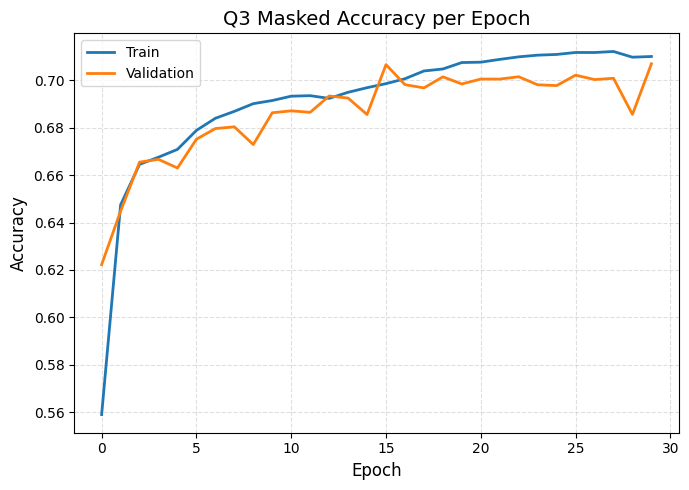

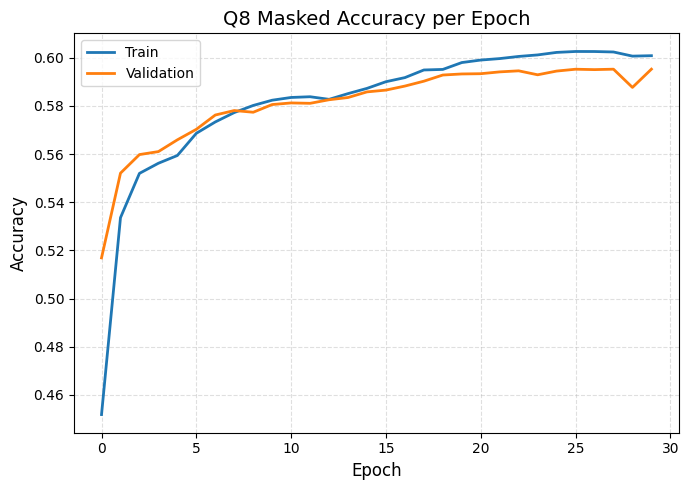

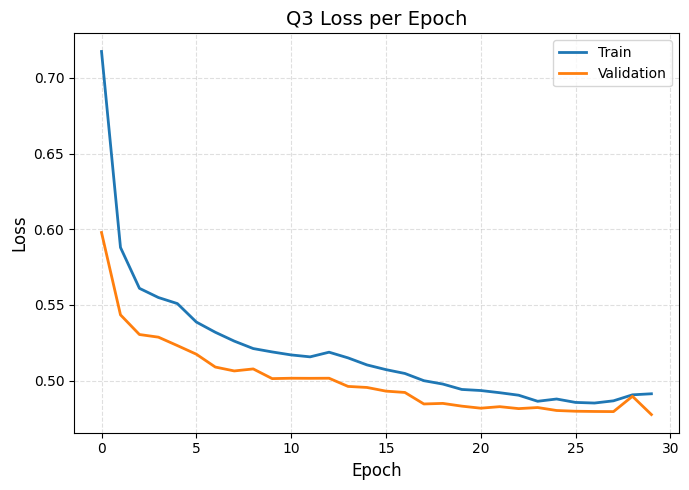

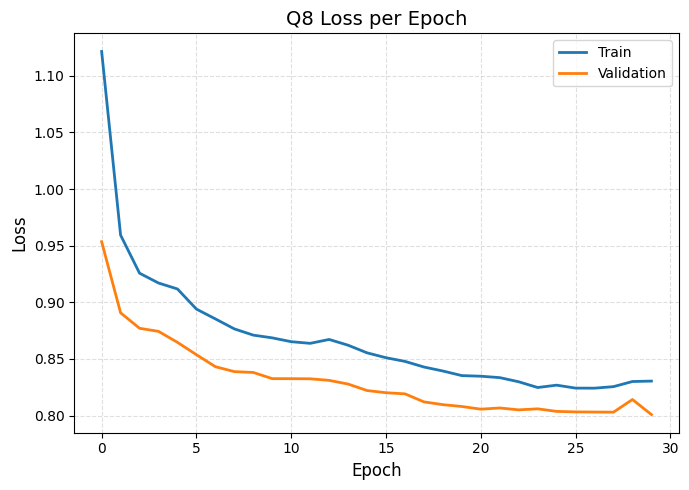

In [ ]:
# Analysis & Visualization
def plot_curve(train, val, title, ylabel):
    plt.figure(figsize=(7,5))
    plt.plot(train, label="Train", linewidth=2)
    plt.plot(val, label="Validation", linewidth=2)
    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot Q3 Accuracy 
plot_curve(
    history.history["q3_masked_acc"],
    history.history["val_q3_masked_acc"],
    "Q3 Masked Accuracy per Epoch",
    "Accuracy"
)

# Plot Q8 Accuracy 
plot_curve(
    history.history["q8_masked_acc"],
    history.history["val_q8_masked_acc"],
    "Q8 Masked Accuracy per Epoch",
    "Accuracy"
)

# Plot Q3 Loss 
plot_curve(
    history.history["q3_loss"],
    history.history["val_q3_loss"],
    "Q3 Loss per Epoch",
    "Loss"
)

# Plot Q8 Loss 
plot_curve(
    history.history["q8_loss"],
    history.history["val_q8_loss"],
    "Q8 Loss per Epoch",
    "Loss"
)


## Test

In [ ]:
pred = model.predict(test_inp, verbose=0)
pred_q8 = np.argmax(pred["q8"], axis=-1)
pred_q3 = np.argmax(pred["q3"], axis=-1)

def masked_acc_np(y_true, y_pred, mask):
    return ((y_true == y_pred) & (mask > 0.5)).sum() / mask.sum()

q8_acc = masked_acc_np(y8te, pred_q8, mte)
q3_acc = masked_acc_np(y3te, pred_q3, mte)

print(f"Test accuracy  Q8: {q8_acc:.4f}  |  Q3: {q3_acc:.4f}")

Test accuracy  Q8: 0.5979  |  Q3: 0.7055
